In [2]:
# Importieren von Bibliotheken
from qiskit import *
from qiskit.circuit.library import QFT

import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

In [3]:
########################################### Funktionen ######################################################################################

def kinetic (circuit, phi):     # Gates zur Simulation der Zeitentwicklung durch H_0
    n = circuit.num_qubits - 1      # Anzahl der Qubits, die in der Simulation genutzt werden

    for i in range(n):
        circuit.p(-phi*2**(i+1),i+1)
        for j in range(i+1,n):
            circuit.cx(j+1,0)
            circuit.cx(i+1,0)
            circuit.p(-phi*2**(i+j+1),0)
            circuit.cx(i+1,0)
            circuit.cx(j+1,0)

    return circuit

def potential (circuit, V):     # Gates zur Simulation des Potentialwalls
    n = circuit.num_qubits - 1
    
    circuit.ccx(n-2, n-3, 0)
    circuit.cp(V, 0, n-1)
    circuit.ccx(n-2, n-3, 0)

def timeEv (circuit, q, phi, V, iterations):      # Zeitentwicklung
    n = circuit.num_qubits - 1      # Anzahl der Qubits, die in der Simulation genutzt werden
    for i in range(iterations):
        circuit.append(QFT(n), q[1:])
        kinetic(circuit=circuit, phi=phi)
        circuit.append(QFT(n, inverse=True), q[1:])
        potential(circuit=circuit, V=V)

    return circuit

In [3]:
########################################### Circuit für Potentialbarriere ###################################################################
""" n = 6

circuit = QuantumCircuit(n+1)  
potential(circuit=circuit, V=np.pi)
circuit.draw('mpl', filename='potentialbarriere.jpg', style={"dpi": 300}) """

' n = 6\n\ncircuit = QuantumCircuit(n+1)  \npotential(circuit=circuit, V=np.pi)\ncircuit.draw(\'mpl\', filename=\'potentialbarriere.jpg\', style={"dpi": 300}) '

In [4]:
########################################### Circuit für Potentialbarriere mit zwei ancillas #################################################
""" n, V = 6, np.pi

circuit = QuantumCircuit(n+2)  

circuit.x(n+1)
circuit.ccx(n+1, n, 1)
circuit.ccx(n-1, n-5, 0)
circuit.cp(V, 0, n-2)
circuit.ccx(n-1, n-5, 0)
circuit.ccx(n+1, n, 1)
circuit.x(n+1)

circuit.draw('mpl', filename='potentialbarriere_ancillas.jpg', style={"dpi": 300}) """

' n, V = 6, np.pi\n\ncircuit = QuantumCircuit(n+2)  \n\ncircuit.x(n+1)\ncircuit.ccx(n+1, n, 1)\ncircuit.ccx(n-1, n-5, 0)\ncircuit.cp(V, 0, n-2)\ncircuit.ccx(n-1, n-5, 0)\ncircuit.ccx(n+1, n, 1)\ncircuit.x(n+1)\n\ncircuit.draw(\'mpl\', filename=\'potentialbarriere_ancillas.jpg\', style={"dpi": 300}) '

C:\Users\Tasnim\Documents\Uni\Physik\Sem.6\Bachelorarbeit\env\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


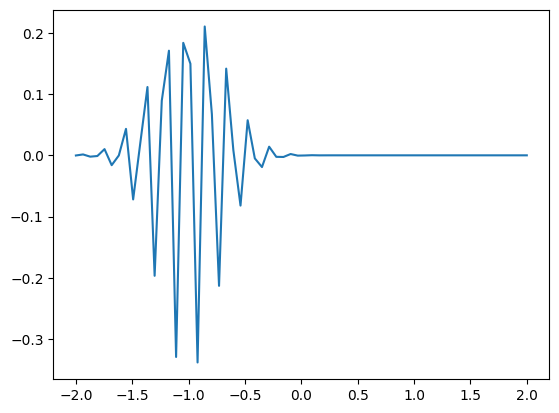

In [12]:
########################################### Startparameter ##################################################################################

n = 6   # Anzahl Qubits
N = 2**n    # Anzahl Gitterpunkte

phi = 0.005
phi = phi/4       # Phasenfaktor

V = 0.3        # Höhe der Potentialstufe

# Ortsraumgitter
x_min = -2
x_max = 2
x = np.linspace(x_min, x_max, num=N)

# Gaußsches Wellenpaket als Anfangszustand
mu=-1
sigma = 0.2
psi= np.sqrt(1/(np.sqrt(2*np.pi)*sigma) * np.exp(-(0.5*(x-mu)**2)/(sigma**2))) * np.exp(-65j*x)
psi/= np.sqrt(np.sum(np.abs(psi**2)))

plt.plot(x, psi)

In [13]:
########################################### Simulation Zustandsvektor #########################################################################

q = QuantumRegister(n+1)    # Erzeugen eines Quantenregisters mit zusätzlichem ancilla-Qubit
circuit = QuantumCircuit(q)   # Erstellen eines circuits

# Initialisierung des Anfangszustandes
circuit.initialize(psi,q[1:])

simulator = Aer.get_backend('statevector_simulator')    # Festlegen des Simulators, hier Zustandsvektor-Simulator

prob_ev = []    # Array, in dem die Zeitentwicklung der Wahrscheinlichkeitsdichte gespeichert wird

# Speichern des Anfangszustandsvektors 
statevector = simulator.run(transpile(circuit, simulator), shots=5000).result().get_statevector()
prob = statevector.probabilities()
prob = prob[::2]
prob_ev.append(prob)

# Simulation der Zustandsvektoren der einzelnen Zeitschritte 
it = 8
rg = 7     # Anzahl der Zeitzwischenschritte die geplottet werden sollen

for i in range(rg):
    timeEv(circuit=circuit, q=q, phi=phi, V=V, iterations=it)
    prob = []
    statevector = simulator.run(transpile(circuit, simulator), shots=5000).result().get_statevector()
    print(str(i) + ':' + str(statevector.is_valid()))       # Ausgabe der Normierungsüberprüfung um Fortschritt der Simulation sichtbar zu machen
    prob = statevector.probabilities()
    prob = prob[::2]
    prob_ev.append(prob)

0:True
1:True
2:True
3:True
4:True
5:True
6:True


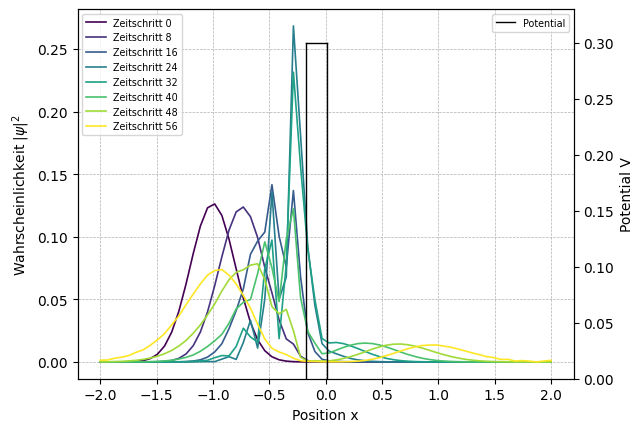

In [19]:
########################################### Plots ################################################################################################

colors = plt.cm.viridis(np.linspace(0,1,rg+1))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# time steps
for i in range(len(prob_ev)):
    ax1.plot(x, prob_ev[i], color=colors[i], linewidth=1.2, label='Zeitschritt ' + str(i*it))

# Potential
ax2.plot([x[28]+1/21, x[28]+1/21], [0, V], color='black', linewidth=1, label='Potential') # Summand 1/21 entspricht der halben Schrittweite, sorgt dafür
ax2.plot([x[31]+1/21, x[31]+1/21], [0, V], color='black', linewidth=1)                    # dass die Potentialbarriere zwischen die Punkte des Ortsgitters
ax2.plot(x[28:32]+1/21, np.full(4, V), color='black', linewidth=1)                        # gezeichnet wird


ax1.set_xlabel('Position x')
ax1.set_ylabel(r'Wahrscheinlichkeit $|\psi|^2$')
ax2.set_ylim(0.0, V+0.1*V)

# Achsenabschnitte um exponentiellen Abfall in der Potentialbarriere größer darzustellen
""" ax1.set_xlim(-0.5,0.5)
ax2.set_ylim(0,0.1)
ax1.set_ylim(0,0.2) """

ax2.set_ylabel('Potential V')
ax1.legend(loc='upper left', fontsize='x-small')
ax2.legend(loc='upper right', fontsize='x-small')
ax1.grid(linestyle='--', linewidth=0.5)

#fig.savefig('timeev_tunnel_V0_3.jpg', bbox_inches="tight",dpi=300)

In [20]:
########################################### Geschwindigkeitsvergleich #######################################################################

# Zeitentwicklung ohne Potential
def timeEv_nopotential (circuit, q, phi, iterations):      
    n = circuit.num_qubits - 1     
    for i in range(iterations):
        circuit.append(QFT(n), q[1:])
        kinetic(circuit=circuit, phi=phi)
        circuit.append(QFT(n, inverse=True), q[1:])

    return circuit

# Simulation der Wahrscheinlichkeitsverteilung ohne Potential
q = QuantumRegister(n+1)    
circuit = QuantumCircuit(q)   
circuit.initialize(psi,q[1:])
simulator = Aer.get_backend('statevector_simulator')   
timeEv_nopotential(circuit=circuit, q=q, phi=phi, iterations=it*rg)
statevector = simulator.run(transpile(circuit, simulator), shots=5000).result().get_statevector()
ref = statevector.probabilities()
ref = ref[::2]

# Anpassen von Gauß-Kurven an die Wahrscheinlichkeitsverteilungen
def gauss (x, a, b, c):
    return a * np.exp(-(0.5*(x-b)**2)/(c**2))

popt1, pcov1 = curve_fit(gauss, x[30:], ref[30:], p0=[0.07, 0.8, 0.8])
popt2, pcov2 = curve_fit(gauss, x[30:], prob_ev[-1][30:], p0=[0.01, 0.9, 0.8])

Peakschwerpunkt ohne Potentialbarriere: 0.8175379741002523+-2.3193011903469997e-05
Peakschwerpunkt mit Potentialbarriere: 0.9612841110102307+-0.004536022407421658


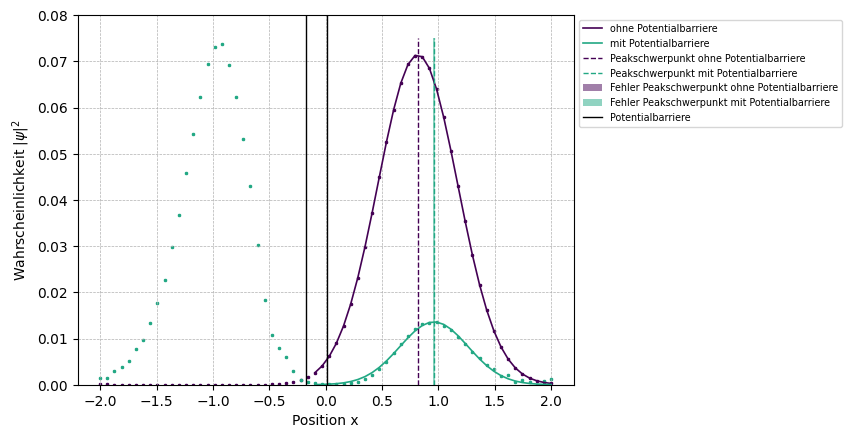

In [25]:
# Plots der Kurven mit Peakschwerpunkt

colors = plt.cm.viridis(np.linspace(0,0.6,2))

plt.plot(x[30:], gauss(x[30:], popt1[0], popt1[1], popt1[2]), color=colors[0], linewidth=1.2, label='ohne Potentialbarriere')
plt.plot(x[30:], gauss(x[30:], popt2[0], popt2[1], popt2[2]), color=colors[1], linewidth=1.2, label='mit Potentialbarriere')
plt.scatter(x, ref, s=3, marker='x', color=colors[0])
plt.scatter(x, prob_ev[-1], s=3, marker='x', color=colors[1])

plt.plot([popt1[1], popt1[1]], [0, 0.075], color=colors[0], linestyle='--', linewidth=1, label='Peakschwerpunkt ohne Potentialbarriere')
plt.plot([popt2[1], popt2[1]], [0, 0.075], color=colors[1], linestyle='--', linewidth=1, label='Peakschwerpunkt mit Potentialbarriere')
plt.axvspan((popt1[1]-np.sqrt(pcov1[1][1])), (popt1[1]+np.sqrt(pcov1[1][1])), ymin=0, ymax=0.075/0.08, facecolor=colors[0], alpha=0.5, label='Fehler Peakschwerpunkt ohne Potentialbarriere')
plt.axvspan(popt2[1]-np.sqrt(pcov2[1][1]), popt2[1]+np.sqrt(pcov2[1][1]), ymin=0, ymax=0.075/0.08, facecolor=colors[1], alpha=0.5, label='Fehler Peakschwerpunkt mit Potentialbarriere')

plt.plot([x[28]+1/21, x[28]+1/21], [0, V], color='black', linewidth=1, label='Potentialbarriere')
plt.plot([x[31]+1/21, x[31]+1/21], [0, V], color='black', linewidth=1)
plt.plot(x[28:32]+1/21, np.full(4, V), color='black', linewidth=1)

plt.ylim(0, 0.08)
#plt.xlim(0,1.8)

plt.xlabel('Position x')
plt.ylabel(r'Wahrscheinlichkeit $|\psi|^2$')
plt.legend(bbox_to_anchor=(1.55,1), fontsize='x-small')
plt.grid(linestyle='--', linewidth=0.5)

print('Peakschwerpunkt ohne Potentialbarriere: ' + str(popt1[1]) + '+-' + str(np.sqrt(pcov1[1][1])))
print('Peakschwerpunkt mit Potentialbarriere: ' + str(popt2[1])+ '+-' + str(np.sqrt(pcov2[1][1])))
ax1.grid(linestyle='--', linewidth=0.5)

#plt.savefig('tunneleffekt_geschwindigkeitsvergleich.jpg', bbox_inches="tight", dpi=300)